# 8장 차원 축소

## 주요 내용

* 차원의 저주

* 차원축소를 위한 접근법
    * 사영 기법
    * 다양체 학습

* 사영 기법 알고리즘
    * PCA(주성분 분석)
    * 커널 PCA

* 다양체 학습 알고리즘
    * LLE(지역 선형임베딩)

## 기본 설정

In [1]:
# 파이썬 ≥3.5 필수 (파이썬 3.7 추천)
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 8.1 차원의 저주

### 고차원 공간의 특징

* 3차원을 초과하는 고차원 공간의 구조를 상상하기는 매우 어려움.

* 고차원 공간의 경우 두 지점 사이의 거리가 매우 멀어질 수 있으며
    이는 특성 수가 많은 데이터들 사이의 거리가 매우 멀어질 수 있음을 의미함.

### 차원의 저주

* 머신러닝에서 다루는 많은 문제가 수 천에서 수 백만의 특성을 가진 데이터를 다룸. 
    이는 데이터셋의 특성이 이루는 공간이 수 천에서 수 백만 차원의 공간임을 의미함.
    
* 수 천에서 수 백만의 차원을 갖는 데이터셋을 훈련시키는 데에 엄청난 시간과 비용이 발생함. 

* 또한 데이터 사이가 멀기 때문에 새로운 데이터에 대한 예측값을 계산하기 위해 많은 추정 과정을 밟아야 하며,
    따라서 과대적합 위험도가 커지는 등 훈련이 매우 어려워짐.

* 데이터 사이의 거리를 충분히 작게 만들기 위해 천문학적 크기의 데이터셋이 요구되기에 사실상 
    해결 불가능한 문제임.

### 차원 축소

* 많은 실전 문제의 데이터셋의 특성들이 이루는 차원을 혁신적으로 줄일 수 있음.

* 예제: MNIST 데이터셋의 경우 손글씨 이미지의 테두리 영역은 거의 항상 흰색이기에 
    숫자 인식을 위해 아무런 역할을 하지 않음. 
    따라서 그 영역을 제외한 특성들의 차원만을 이용할 수 있음.
    실제로 784(= 18 * 18)개의 픽셀 특성 대신에 154개의 픽셀 특성만을 사용해도
    숫자 분류를 진행할 수 있음을 아래에서 확일할 것임.
    
* 차원축소: 고차원의 데이터셋을 저차원의 데이터셋으로 변환하는 과정

#### 장점과 단점

- 차원축소를 진행하면 정보를 일부 또는 상당히 잃게 됨. 
    따라서 적절한 수의 차원으로 축소를 진행해야 하며 어느 정도로 줄이는 것이 적절한지 먼저 알아내야 함.
    
- 반면에 차원축소 후 훈련 속도가 보다 많이 빨라짐.
- 또한 2, 3차원으로 줄일 경우 데이터 시각화가 가능해져서 데이터들의 패턴을 인식 가능해질 수 있음.

## 8.2 차원축소 기법 소개

### 8.2.1 사영 기법

특잇값 분해를 이용한 사영 기법을 설명하기 위해 
3차원 공간에 아래와 같이 분포된 60개의 점을 2차원으로 사영하는 예제를 이용한다. 

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml2/master/slides/images/ch08/homl08-02a.png" width="500"/></div>

언급된 60개의 3차원 데이터는 아래와 같이 (60, 3) 모양의 행렬 `X`로 생성한다.

__참고:__ 생성되는 데이터의 x, y 좌표는 사인, 코사인 함수를 조합하며,
수학적으로 큰 의미는 없다.

In [3]:
np.random.seed(4)

m = 60
noise = 0.1

X = np.empty((m, 3))

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2   # x 좌표
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2                # y 좌표

w1, w2 = 0.1, 0.3
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)             # z 좌표 (초평면 + 잡음)

#### PCA(주성분 분석)

데이터셋의 주성분은 데이터 샘플들의 분산을 최대로 유지하는 축을 가리키며 차원의 개수만큼 주성분이 존재한다.
분산을 최대로 유지하는 축이 첫째 주성분이며, 이후의 축은 이전 축에 수직이면서 동시에 남은 분산을 최대한
보존하는 축으로 지정한다. 이 과정을 차원 수 만큼의 주성분을 찾을 때까지 반복한다. 

#### 차원축소

차원축소는 PCA를 통해 찾은 주성분의 일부로 구성된 초평면(하이퍼플레인hyperplane)으로 
데이터 샘플을 사영(projection)하는 과정을 의미한다.

첫째부터 $d$ 번째 까지의 주성분을 축으로 사용해서 생성되는 $d$ 차원의 공간으로 데이터셋이 사영된다. 
따라서 3차원 데이터를 2차원 공간으로 보내려면 예를 들어 아래 그림의 회색 평면을 구성하는
두 개의 축에 해당하는 주성분을 찾아야 한다.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml2/master/slides/images/ch08/homl08-02b.png" width="500"/></div>

#### 특잇값 분해(SVD)

데이터셋의 분산에 대한 주성분은 데이터셋 행렬의 특잇값 분해(SVD, singular value decomposition)를
이용하여 쉽게 구할 수 있다.
사이킷런의 `PCA` 모델이 특잇값 분해를 이용하여 주성분을 바로 계산할 수 있지만 여기서는 먼저 
특잇값 분해를 사용하여 직접 주성분을 구하는 과정을 살펴본다.

__주의사항:__ 평균값(mean)이 $0$이라는 가정하에 특잇값 분해를 진행해야 하기에
아래 코드를 먼저 실행한다.

In [4]:
X_centered = X - X.mean(axis=0)

특잇값 분해의 내용은 다음과 같다.

평균값이 0인 데이터셋 $X$가 주어졌을 때 아래 조건을 만족시키는 세 개의 행렬 $U$, $\Sigma$, $V$가 존재한다. 

$$
X = U\, \Sigma \, V^{\!T}
$$

- $X$: m x n 행렬
- $U$: m x m 행렬
- $\Sigma$: m x n 모양의 대각행렬(diagonal matrix). 
- $V$: n x n 행렬. 윗첨자 $T$는 전치행렬을 의미함.

__참고:__ [위키백과: 특잇값 분해](https://ko.wikipedia.org/wiki/%ED%8A%B9%EC%9E%87%EA%B0%92_%EB%B6%84%ED%95%B4)

특잇값 분해를 진행하는 `numpy.linalg.svd()` 함수를 이용하여
`X_centered`에 대해 특잇값 분해를 진행한 결과는 다음과 같다.

- `s`: 대각행렬 $\Sigma$에 해당하지만 대각선상에 위치한 값들만 모아 놓은 길이 3인 1차원 어레이임.
- `Vt`: $V^{\!T}$, 즉 행렬 $V$의 전치행렬에 해당함.

In [5]:
U, s, Vt = np.linalg.svd(X_centered)

각 행렬의 모양을 확인하면 다음과 같다.

In [6]:
U.shape

(60, 60)

앞서 언급한 대로 `s`는 원래 (60, 3) 모양의 대각 행렬 이어야 하지만 
여기서는 대각선 상에 위치한 세 개의 수만 포함하고 있다.

__참고:__ (60, 3) 모양의 대각선은 길이가 3이다. 

In [7]:
s.shape

(3,)

In [8]:
Vt.shape

(3, 3)

특잇값 분해가 제대로 이루어진 것인지 아래와 같이 검증할 수 있다.

__주의사항:__ 행렬의 곱셈을 진행하려면 먼저 `s`를 (60, 3) 모양의 대각 행렬로 만들어야 한다. 

In [9]:
S = np.zeros(X_centered.shape)
S[:3, :3] = np.diag(s)

이제 아래와 같이 특잇값 분해가 제대로 이루어졌음을 확인할 수 있다.

__참고:__ 컴퓨터를 이용한 부동소수점 연산은 일반적으로 100% 정확하지 않다.
따라서 약간의 오차를 감안하여 두 부동소수점 값을 비교해야 한다.
`numpy.allclose()` 함수는 지정된 오차범위 안에서 두 부동소수점의 일치여부를 판단한다.
보다 자세한 설명은 
[numpy.allclose 문서](https://runebook.dev/ko/docs/numpy/reference/generated/numpy.allclose)를
참조한다.

In [10]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

주성분은 앞서 특잇값 분해로 얻은 행렬 $V$의 열 벡터에 해당한다.
0번 열이 첫째 주성분, 1번 열이 둘째 주성분, 2번 열이 셋재 주성분 벡터이다. 
아래 그림은 첫째 주성분 벡터를 보여준다.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml2/master/slides/images/ch08/homl08-02c.png" width="600"/></div>

첫째와 둘째 주성분 벡터를 함께 그리면 다음과 같다.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml2/master/slides/images/ch08/homl08-02d.png" width="600"/></div>

#### 2차원으로 사영하기

3차원 공간의 데이터를 2차원으로 보내려면 앞서 보여준 두 개의 주성분(principal components)을 선택한 후에
두 축에 의해 생성되는 초평면hyperplane에 사영해야 한다. 
2차원으로 사영하려면 따라서 행렬 $V$의 0번과 1번 두 개의 열을 선택한 후에
`X_centered`를 두 개의 주성분으로 구성된 행렬과 곱한다. 

__주의사항:__ `Vt.T` 는 $(V^{\!T})^{T}$, 즉 $V$를 가리킨다.

In [11]:
W2 = Vt.T[:, :2]           # 주성분 2개 선택

X2D = X_centered.dot(W2)   # 데이터셋을 2차원으로 사영

사영된 데이터셋은 다음과 같다.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml2/master/slides/images/ch08/homl08-02d.png" width="600"/></div>

사영된 데이터셋을 이어서 소개하는 사이킷런의 `PCA` 모델을 이용하여 구한 값과의
비교를 위해 잠시 기억해둔다.

In [12]:
X2D_using_svd = X2D

#### 사이킷런의 PCA 모델 활용

앞서 특잇값 분해를 직접 활용하여 2차원으로 사영하는 과정을 
사이킷런의 `PCA` 모델을 이용하여 간단하게 해결할 수 있다.

__참고:__ 평균값을 0으로 맞추는 것도 `PCA` 모델이 알아서 처리한다. 

- `fit()`: 평균값을 0으로 맞춘 후 특잇값 분해를 이용하여 주성분을 찾는다.
- `transform()`: 찾은 주성분 2개를 이용하여 2차원 공간으로 데이터셋을 사영하는 과정은 다음과 같다.
    - 평균값을 0으로 맞춘다.
    - 특잇값 분해로 찾은 주성분을 이용하여 2차원으로 사영한다.

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)   # 2차원으로 사영하는 모델
X2D = pca.fit_transform(X)

__참고:__ 사영된 데이터의 축별 평균은 거의 0이다.

In [14]:
X2D.mean(0)

array([7.40148683e-18, 9.71445147e-18])

__주의사항:__ 사이킷런을 이용하여 PCA를 진행할 때 주성분 축이 반대 방향으로 지정되는 경우가 발생할 수 있으며
여기서도 그런 일이 벌어졌음을 아래 코드가 알려준다. 

In [15]:
np.allclose(X2D, X2D_using_svd)

False

In [16]:
np.allclose(X2D, - X2D_using_svd)

True

실제로 훈련된 `PCA`가 알고 있는 주성분과 앞서 특잇값 분해로 얻은 주성분이
서로 반대방향을 가리키고 있다.

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [19]:
np.allclose(pca.components_, - Vt[:2])

True

#### 재구성 오차

아래 코드는 2차원으로 사영된 데이터를 다시 3차원으로 복원한다. 

In [20]:
X3D_inv = pca.inverse_transform(X2D)

그런데 2차원 공간으로 사영되면서 정보손실이 있었기에 3차원으로 복원한 값과
원래의 3차원 값 사이에 오차가 존재한다.

In [21]:
np.allclose(X3D_inv, X)

False

재구성 오차(reconstruction error)는 사영 전과 
사영 후 원래 공간으로 복원한 데이터 사이의 평균제곱오차로 계산한다.

In [22]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

__참고:__ `inverse_transform()` 메서드가 내부에서는 사영할 때 사용된 행렬의 전치행렬을
사영된 데이터셋에 곱한다.

In [23]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

앞서 구한 `inverse_transform()` 메서드의 결과와 비교하기 위해선 다시 데이터셋의 평균값을 빼주어야 한다.

In [24]:
X.mean(0)

array([0.02406745, 0.20932515, 0.07155422])

그런데 `PCA` 모델의 `mean_` 속성에 동일한 값이 저장되어 있다. 

In [25]:
pca.mean_

array([0.02406745, 0.20932515, 0.07155422])

이제 두 값을 비교하면 다음과 같이 일치한다. 

In [26]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

#### 설명 분산 비율

설명 분산 비율은 각 주성분의 축에 대한 데이텃셈의 분산 비율을 의미한다. 
`PCA` 객체의 `explained_variance_ratio_` 속성에 사영에 사용된 주성분별 설명 분산 비율이 저장되어 있다.

- 첫째 주성분의 축에 대한 데이터셋의 분산 비율:84.25%
- 둘째 주성분의 축에 대한 데이터셋의 분산 비율:14.63%

In [27]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

즉, 2차원으로 사영한 결과 1.1% 정도의 분산을 잃는다.

In [28]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

__참고:__ 특잇값 분해로 생성된 행렬 `s`를 이용하여 모든 주성분에 대한 
설명 분산 비율을 계산할 수 있다.

In [29]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

#### 사영 그래프 그리기

3차원 데이터셋을 2차원 데이터셋으로 사영한 결과를 그래프로 확인해 보자.

* 아래 코드는 3차원 화살표를 그리는 함수를 정의한다. 

__참조:__ [Plotting a 3d cube, a sphere and a vector in Matplotlib](http://stackoverflow.com/questions/11140163)

In [30]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

- 3차원 공간에서의 2차원 평면 좌표는 다음과 같다.

In [31]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)                      # x축, y축 좌표

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])   # z축 좌표

* 그래프 그리기: 3D 데이터셋, 평면, 그리고 사영 과정

Saving figure dataset_3d_plot


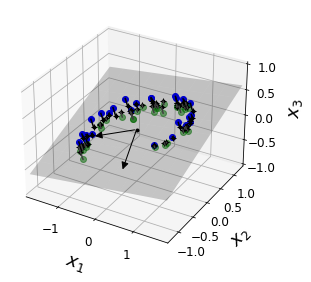

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

# 3차원 데이터 산점도 그리기: 초평면 윗쪽, 아랫쪽 데이터 구분
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]    # 초평면 윗쪽 데이터
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]   # 초평면 아랫쪽 데이터

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "go", alpha=0.5)

# 주성분의 축 그리기
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# 초평면 그리기
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")

ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# 초평면으로 사영된 데이터셋 그리기
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")

# 사영 과정
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

Saving figure dataset_3d_plot


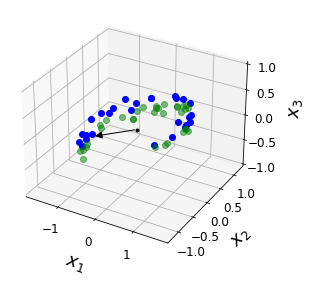

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

# 3차원 데이터 산점도 그리기: 초평면 윗쪽, 아랫쪽 데이터 구분
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]    # 초평면 윗쪽 데이터
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]   # 초평면 아랫쪽 데이터

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "go", alpha=0.5)

# 주성분의 축 그리기
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
# ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# 초평면 그리기
# ax.plot_surface(x1, x2, z, alpha=0.2, color="k")

# 초평면으로 사영된 데이터셋 그리기
# ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
# ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")

# 사영 과정
# for i in range(m):
#     if X[i, 2] > X3D_inv[i, 2]:
#         ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
#     else:
#         ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")

# 축 레이블 표기
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

* 2차원 공간으로 사영된 데이터셋 그리기

Saving figure dataset_2d_plot


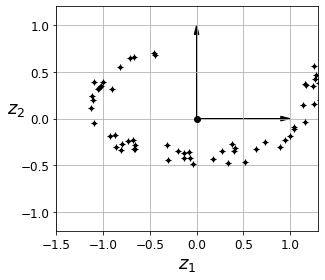

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

### 8.2.2 다양체 학습

#### 롤케이크 그리기

__참고:__ 롤케이크를 영어로 스위스 롤(Swiss roll)이라 부른다.

In [ ]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

#### 롤케이크 사영하기와 펼치기

In [ ]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

#### 다양체 가정

In [ ]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

## PCA

### 분산 보존

In [ ]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

### MNIST 압축하기

__주의사항:__ 사이킷런 0.24 버전부터 `fetch_openml()`이 `DataFrame` 또는 `Series` 객체를
이용하여 데이터셋을 반환한다.
이를 방지하기 위해 `as_frame=False` 옵션을 설정한다.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

설명 분산 비율이 95%가 되도록 하는 차원을 확인하면 154이다.

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

d

설명 분산 비율과 차원과의 관계를 그래프로 그리면 다음과 같다.

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

차원을 직접 지정하는 대신 설명 분산 비율을 지정하면
자동으로 해당 분산 비율을 만족하는 최소 차원으로 데이터셋을 사영한다.

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

In [ ]:
np.sum(pca.explained_variance_ratio_)

재구성 오차는 다음과 같다.

In [ ]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
np.mean(np.sum(np.square(X_recovered - X_train), axis=1))

원본 손글씨 숫자와 재구성된 숫자 이미지를 비교해보자.

In [ ]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

이어서 설명하는 점진전 PCA의 결과와 비교하기 위해
PCA 기법으로 압축된 손글씨 이미지 데이터를 `X_reduced_pca` 로 기억해두자.

In [ ]:
X_reduced_pca = X_reduced

### 점진적 PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [ ]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [ ]:
np.allclose(pca.mean_, inc_pca.mean_)

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [ ]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

#### `memmap()` 함수 사용하기

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [ ]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [ ]:
del X_mm

Next, another program would load the data and use it for training:

In [ ]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

#### 시간 복잡도 비교

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [ ]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

In [ ]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

In [ ]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## 커널 PCA

#### 그림 8-10 코드

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

#### 그림 8-11 코드

In [ ]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

In [ ]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

In [ ]:
print(grid_search.best_params_)

In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

## LLE

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

## 기타 차원축소 기법

#### 그림 8-13 코드

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

In [ ]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

## 연습문제 해법

### 1. to 8.

See appendix A.

### 9.

*Exercise: Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).*

The MNIST dataset was loaded earlier.

In [ ]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

*Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.*

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*Exercise: Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?*

In [ ]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the `manifold_decision_boundary_plot*` plots above). If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

*Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?*

In [ ]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

Let's see if it helps when using softmax regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

In [ ]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. Let's train the softmax regression model using the reduced dataset:

In [ ]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Nice! Reducing dimensionality led to over 2× speedup. :)  Let's check the model's accuracy:

In [ ]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

A very slight drop in performance, which might be a reasonable price to pay for a 2× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always!

### 10.

*Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.*

The MNIST dataset was loaded above.

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [ ]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 3 and 5, which seem to overlap a lot.

In [ ]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [ ]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

In [ ]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now. 

*Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

In [ ]:
plot_digits(X_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

In [ ]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

In [ ]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.*

Let's start with PCA. We will also time how long it takes:

In [ ]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

In [ ]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

In [ ]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

In [ ]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

In [ ]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

In [ ]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us over 2x speedup, without damaging the result. We have a winner!